# Example interactions with code modules

In [1]:
import numpy as np
from qiskit import execute, Aer
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import *
import matplotlib.pyplot as plt
import logging
import time
import copy

from IPython.core.display import display, HTML
from IPython.display import IFrame
from pyvis import network as net

from plerco.pec_python.qec_code.rssc import RSSC
from plerco.pec_python.qec_circuit.rssc_circuit import RSSCCircuit
from plerco.pec_python.qec_decoder.rssc_decoder import RSSCDecoder

from plerco.pec_python.qec_code.hhc import HHC
from plerco.pec_python.qec_circuit.hhc_circuit import HHCCircuit
from plerco.pec_python.qec_decoder.hhc_decoder import HHCDecoder

from plerco.pec_python.qec_noise_model.paulinoisemodel import PauliNoiseModel
from plerco.pec_python.configuration.config import Config

logging.basicConfig(filename='output.log', filemode='w', level=logging.INFO)

def make_model(p):
    """Make a Pauli model for depolarizing noise."""
    pnm = PauliNoiseModel()
    pnm.add_operation("cx", {"ix": 1, "iy": 1, "iz": 1,
                             "xi": 1, "xx": 1, "xy": 1, "xz": 1,
                             "yi": 1, "yx": 1, "yy": 1, "yz": 1,
                             "zi": 1, "zx": 1, "zy": 1,
                             "zz": 1})
    pnm.add_operation("id", {"x": 1, "y": 1, "z": 1})
    pnm.add_operation("reset", {"x": 1})
    pnm.add_operation("measure", {"x": 1})
    pnm.add_operation("h", {"x": 1, "y": 1, "z": 1})
    pnm.add_operation("x", {"x": 1, "y": 1, "z": 1})
    pnm.add_operation("y", {"x": 1, "y": 1, "z": 1})
    pnm.add_operation("z", {"x": 1, "y": 1, "z": 1})
    pnm.add_operation("idm", {"x": 1, "y": 1, "z": 1})
    pnm.set_error_probability("cx", p)
    pnm.set_error_probability("id", p)
    pnm.set_error_probability("reset", p)
    pnm.set_error_probability("measure", p)
    pnm.set_error_probability("h", p)
    pnm.set_error_probability("x", p)
    pnm.set_error_probability("y", p)
    pnm.set_error_probability("z", p)
    pnm.set_error_probability("idm", p)
    return pnm

def make_model_7(p_cx, p_id, p_reset, p_meas, p_idm, p_single, p_z=0.0):
    """Make a Pauli model for depolarizing noise."""
    pnm = PauliNoiseModel()
    pnm.add_operation("cx", {"ix": 1, "iy": 1, "iz": 1,
                             "xi": 1, "xx": 1, "xy": 1, "xz": 1,
                             "yi": 1, "yx": 1, "yy": 1, "yz": 1,
                             "zi": 1, "zx": 1, "zy": 1,
                             "zz": 1})
    pnm.add_operation("id", {"x": 1, "y": 1, "z": 1})
    pnm.add_operation("reset", {"x": 1})
    pnm.add_operation("measure", {"x": 1})
    pnm.add_operation("h", {"x": 1, "y": 1, "z": 1})
    pnm.add_operation("x", {"x": 1, "y": 1, "z": 1})
    pnm.add_operation("y", {"x": 1, "y": 1, "z": 1})
    pnm.add_operation("z", {"x": 1, "y": 1, "z": 1})
    pnm.add_operation("idm", {"x": 1, "y": 1, "z": 1})
    pnm.set_error_probability("cx", p_cx)
    pnm.set_error_probability("id", p_id)
    pnm.set_error_probability("reset", p_reset)
    pnm.set_error_probability("measure", p_meas)
    pnm.set_error_probability("h", p_single)
    pnm.set_error_probability("x", p_single)
    pnm.set_error_probability("y", p_single)
    pnm.set_error_probability("z", p_z)
    pnm.set_error_probability("idm", p_idm)
    return pnm

def run_circuit(qc, shots, model=None, seed=100):
    """Simulate a circuit with the stabilizer simulator.
    
    qc = QuantumCircuit to simulate
    shots = number of shots to run
    model = noise model to use, None if no noise
    seed = seed value for random number generator
    
    Return the dictionary of counts.
    """
    qasmsim = Aer.get_backend('qasm_simulator')
    if model is None:
        result = execute(qc, qasmsim, method="stabilizer", shots=shots,
                         optimization_level=0, seed_simulator=seed).result()
    else:
        result = execute(qc, qasmsim, 
                         noise_model=model.as_aer_noise_model(),
                         basis_gates=model.as_aer_noise_model().basis_gates,
                         method="stabilizer",
                         shots=shots,
                         optimization_level=0,
                         seed_simulator=seed).result()
    return result.get_counts(qc)

def sigma(p, shots):
    """Compute the sample standard deviation.
    
    p = Bernoulli parameter
    shots = number of samples
    
    Return the value.
    """
    return np.sqrt(p * (1-p)/float(shots-1))

def sim(circ, shots, decoder, code, model, basis, input_state, printtime=False):
    tic = time.perf_counter()
    counts_n = run_circuit(circ, shots, model)
    toc = time.perf_counter()
    if printtime:
        print(f"simulate circuits in {toc - tic:0.4f} seconds")
    decoder.update_edge_weights(model)
    tic = time.perf_counter()
    failures = 0
    for (outcome, num) in counts_n.items():
        reversed_outcome = list(map(int, outcome[::-1]))  # convert to list of integers
        corrected_outcomes = decoder.process(reversed_outcome)
        if basis == 'z':
            fail = code.logical_x_error(corrected_outcomes)
        elif basis == 'x':
            fail = code.logical_z_error(corrected_outcomes)
        if input_state == '-':
            fail[0] = (fail[0] + 1) % 2
        if bool(fail[0]):
            failures += num
    toc = time.perf_counter()
    if printtime:
        print(f"decode outcomes in {toc - tic:0.4f} seconds")
    pfail = float(failures)/float(shots)
    sig = sigma(pfail, shots)
    return pfail, sig

def scan_hhc(shots, pin, d, rounds, round_schedule, basis, input_state):
    pfails = []
    sigs = []
    print('scanning %d %d %s %s %s' % (d, rounds, round_schedule, basis, input_state))
    config = Config()
    config["code"]["d"] = d
    config["circuit"]["schedule"] = "heavy-hex"
    config["circuit"]["rounds"] = rounds
    config["circuit"]["round_schedule"] = round_schedule
    config["circuit"]["basis"] = basis
    config["circuit"]["inital_state"] = input_state
    config["decoder"]["method"] = "matching_pymatching"
    code = HHC(config["code"]["d"])
    gen = HHCCircuit(code, config)
    circ = gen.syndrome_measurement()
    model = make_model(0.01)  # arbitrary p
    tic = time.perf_counter()
    decoder = HHCDecoder(code, circ, model, config)
    toc = time.perf_counter()
    print(f"construct decoder in {toc - tic:0.4f} seconds")
    for p in pin:
        model = make_model(p)
        print('running %d %f' % (shots, p))
        pf, s = sim(circ, shots, p, decoder, code, model, basis, input_state)
        pfails.append(pf)
        sigs.append(s)
    return pfails, sigs

def make_input_graph(decoding_graph):
    """Copy and adjust a decoding graph for display by pyviz.

    decoding_graph = input decoding graph
    Return networkx graph for display.
    """
    graph = copy.deepcopy(decoding_graph)
    # Make edge attributes serializable and add color and title
    for u, v, a in graph.edges(data=True):
        if "weight_poly" in a:
            a["weight_poly"] = str(a["weight_poly"])
            a["title"] = a["weight_poly"] + ", qubit=" + str(a["qubit_id"])
        else:
            a["title"] = str(a["weight"]) + ", qubit=" + str(a["qubit_id"])
        if a["measurement_error"] == 1:
            a["color"] = "green"
        else:
            a["color"] = "black"
    # Add size, title, and color node attributes
    for n, a in graph.nodes(data=True):
        if "is_boundary" in a and a["is_boundary"]:
            a["size"] = 30
        else:
            a["size"] = 50
        a["title"] = str(a["qubits"])  # visible on mouseover
        colors = ["red", "blue"]
        a["color"] = colors[a["time"] % len(colors)]
    return graph

def sim_hhc_config(shots, config, model=None, printtime=False):
    d = config["code"]["d"]
    rounds = config["circuit"]["rounds"]
    round_schedule = config["circuit"]["round_schedule"]
    basis = config["circuit"]["basis"]
    input_state = config["circuit"]["initial_state"]
    print('Running %d shots of %d %d %s %s %s' % (shots, d, rounds, round_schedule, basis, input_state))
    code = HHC(config["code"]["d"])
    gen = HHCCircuit(code, config)
    circ = gen.syndrome_measurement()
    if model is None:
        model = PauliNoiseModel(config["noise"])
    else:
        model = model
    tic = time.perf_counter()
    decoder = HHCDecoder(code, circ, model, config)
    toc = time.perf_counter()
    if printtime:
        print(f"construct decoder in {toc - tic:0.4f} seconds")
        print('running sim for %s shots'%shots)   
    pfail, sig = sim(circ, shots, decoder, code, model, basis, input_state, printtime=printtime)
    return pfail, sig, circ

In [2]:
def show_figure(fig):
    new_fig = plt.figure()
    new_mngr = new_fig.canvas.manager
    new_mngr.canvas.figure = fig
    fig.set_canvas(new_mngr.canvas)
    plt.show(fig)

Experimental circuit


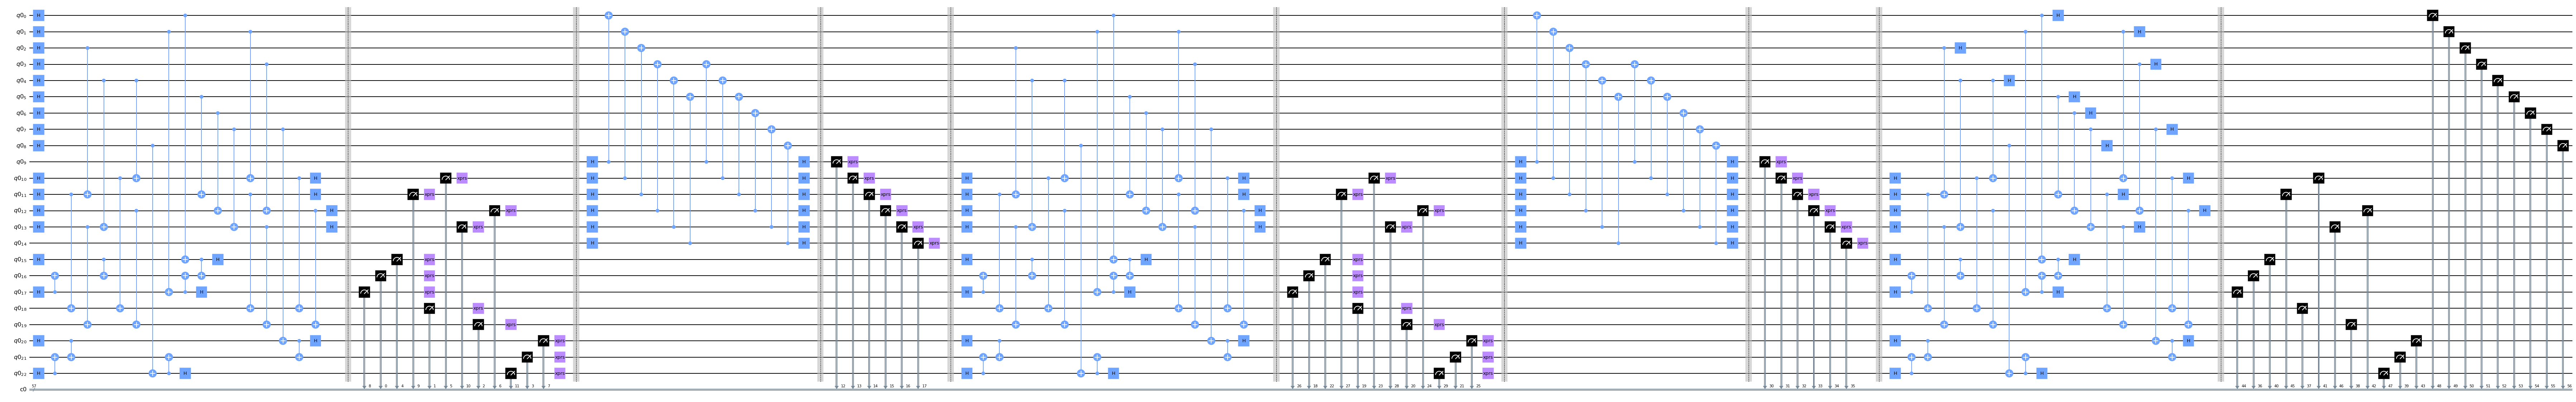

With idles


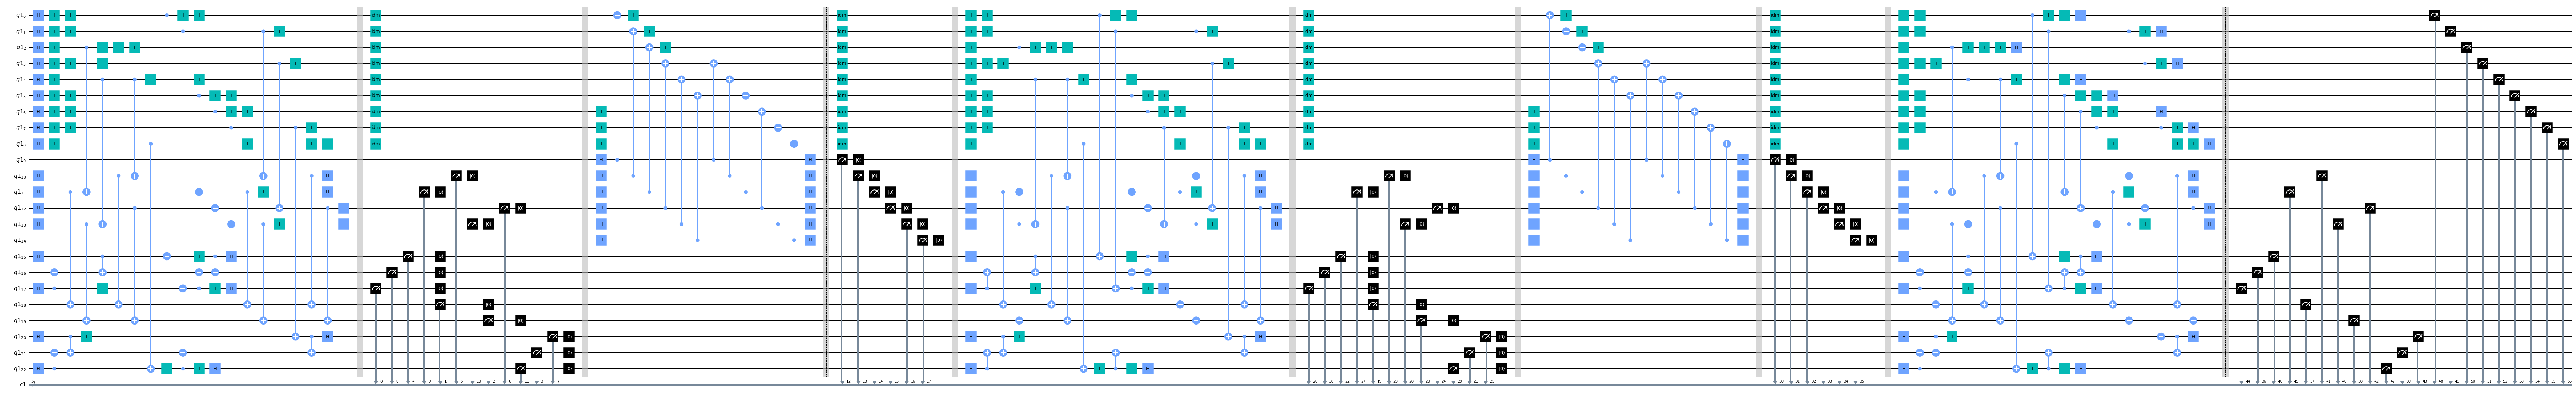

In [3]:
# Experiment EXAMPLE
config_exp = Config()
config_exp["code"]["d"] = 3
config_exp["circuit"]["schedule"] = "heavy-hex"
config_exp["circuit"]["rounds"] = 1
config_exp["circuit"]["round_schedule"] = 'zxzxz'
config_exp["circuit"]["basis"] = 'x'
code = HHC(config_exp["code"]["d"])

#config["circuit"]["initial_state"] = '+' # default
#config["circuit"]["logical_paulis"] = '' # default
config_exp["circuit"]["barriers"] = False  
config_exp["circuit"]["idles"] = False  
#config["circuit"]["distinct_measurement_idle"] = True # default
config_exp["circuit"]["num_initialize"]= 0 
config_exp["circuit"]["group_meas"]= True 
config_exp["circuit"]["xprs"]= True  # default

gen_exp = HHCCircuit(code, config_exp)
circ_exp = gen_exp.syndrome_measurement()
fig_exp=circ_exp.draw(output="mpl", fold=-1)
print('Experimental circuit')
show_figure(fig_exp)



### Add identities and reset instead of xprs to use for decoder
config_sim = copy.deepcopy(config_exp)
config_sim["circuit"]["idles"] = True
config_sim["circuit"]["xprs"]= False

gen_sim = HHCCircuit(code, config_sim)
circ_sim = gen_sim.syndrome_measurement()
fig_sim=circ_sim.draw(output="mpl", fold=-1)
print('With idles')
show_figure(fig_sim)

In [4]:
config_dec=copy.deepcopy(config_sim)
config_dec["decoder"]["method"] = "matching_pymatching"
model = make_model_7(p_cx=0.01, p_id=0.0005, p_reset=0.01, p_meas=0.01, p_idm=0.002, p_single=0.0005, p_z=0.0)
for uniform_dec in [True,False]:
    config_dec["decoder"]["uniform"] = uniform_dec
    unitext='Uniform ' if uniform_dec else  'Analytical '
    decoder = HHCDecoder(code, circ_sim, model, config_dec)

    pfail, sig, circ = sim_hhc_config(shots=1000, config=config_dec, model=model)
    print('%serror %s\n'%(unitext,pfail))

Running 1000 shots of 3 1 zxzxz x +
Uniform error 0.119

Running 1000 shots of 3 1 zxzxz x +
Analytical error 0.105

